# Project: Investigate a Dataset from "The Movie Data Base"

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The [Internet Movie Database](https://en.wikipedia.org/wiki/IMDb) (abbreviated [IMDb](http://www.imdb.com/) is an online database of information related to films, television programs and video games, including cast, production crew, fictional characters, biographies, plot summaries, trivia and reviews, operated by IMDb.com, Inc., a subsidiary of Amazon. As of October 2017, IMDb has approximately 4.6 million titles (including episodes), 8.2 million personalities in its database,as well as 80 million registered users.
The site enables registered users to submit new material and edits to existing entries.


The data set to be investigated contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.
Certain columns, like ‘cast’ and ‘genres’, contain multiple values separated by pipe (|) characters

Two questions will be investigated:
Which genres are most popular from year to year? What kinds of properties are associated with movies that have high revenues?




In [1]:
# All imports needed to perform the whole project:

import unicodecsv
from datetime import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


<a id='wrangling'></a>
## Data Wrangling


### General Properties

I load my data and print out a few lines to understand the data structure

In [2]:
movies = pd.read_csv('tmdb-movies.csv')
print movies.head(5)
print movies.shape
length = movies.shape[0]

       id    imdb_id  popularity     budget     revenue  \
0  135397  tt0369610   32.985763  150000000  1513528810   
1   76341  tt1392190   28.419936  150000000   378436354   
2  262500  tt2908446   13.112507  110000000   295238201   
3  140607  tt2488496   11.173104  200000000  2068178225   
4  168259  tt2820852    9.335014  190000000  1506249360   

                 original_title  \
0                Jurassic World   
1            Mad Max: Fury Road   
2                     Insurgent   
3  Star Wars: The Force Awakens   
4                     Furious 7   

                                                cast  \
0  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...   
1  Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...   
2  Shailene Woodley|Theo James|Kate Winslet|Ansel...   
3  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...   
4  Vin Diesel|Paul Walker|Jason Statham|Michelle ...   

                                            homepage          director  \
0                      

I write two functions to investigate duplicates and NaNs in columns

In [3]:
def investigate_duplicates(data_df, col, length):
    """This function explores duplicates for a given column (attribute) by using the unique method.
    The goal is not to automate but to print data to aid the decision. Printing data helps to analyze the similarity
    of rows sharing the same attribute. Cleaning shall be made afterwards.
    """
    unique_ids = data_df[col].unique()
    length_unique = len(unique_ids)
#   Preliminary tests show that when the field is NaN, the row index is not kept in unique: 
#   unique removes duplicate(s) and NaN(s)
    print length-length_unique,'duplicate(s)'
#   Print duplicates to analyze if duplicated lines are similar
    current_list=[]
    index_list=[]
    for index, datum in data_df.iterrows():
        current_id = datum[col]
        if (current_id in unique_ids) and (current_id not in current_list):
            current_list.append(current_id)
        else:
            print datum
            index_list.append(index)
    print index_list
    print data_df.ix[index_list,col]
    grouped = data_df.groupby(col)
    for name,group in grouped :
        if len(group) > 1 : 
            print name,group

def investigate_NaNs(data_df, col):
    """This function investigate NaNs for a given column printing the rows with NaNs to assess
    the quality of the information for this row
    """
    data_with_NaN = data_df[pd.isnull(data_df[col])]
    print data_with_NaN
    print len(data_with_NaN),' rows with NaN'

I am now investigating duplicates and NaNs for the 'id' column

In [4]:
investigate_duplicates(movies, 'id', length)
investigate_NaNs(movies, 'id')

1 duplicate(s)
id                                                                  42194
imdb_id                                                         tt0411951
popularity                                                        0.59643
budget                                                           30000000
revenue                                                            967000
original_title                                                     TEKKEN
cast                    Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...
homepage                                                              NaN
director                                                 Dwight H. Little
tagline                                               Survival is no game
keywords                martial arts|dystopia|based on video game|mart...
overview                In the year of 2039, after World Wars destroy ...
runtime                                                                92
genres                 

I found one duplication and after print it looks like this is a real duplication: the two rows look really identical. I can remove the second row without losing information.
No NaN for the 'id' attribute.

I now investigate duplicates and NaNs for the 'imdb_id' attribute

In [5]:
investigate_duplicates(movies, 'imdb_id', length)
investigate_NaNs(movies, 'imdb_id')

10 duplicate(s)
id                                                                 355131
imdb_id                                                               NaN
popularity                                                       0.108072
budget                                                                  0
revenue                                                                 0
original_title                                 Sense8: Creating the World
cast                    Tuppence Middleton|Bae Doona |Brian J. Smith|A...
homepage                                                              NaN
director                                                              NaN
tagline                                                               NaN
keywords                sexuality|superhuman|superpower|making of|soci...
overview                                                              NaN
runtime                                                                25
genres                

I found 10 duplicates but which are not real duplicates because there is 'idmb_id' attribute is NaN.
Looking at the rows with NaN as 'idmb_id' attribute, they carry valid information: we can keep them.
The fact that the idmb_id is missing should not be a trouble.

In [6]:
print movies.ix[2089] == movies.ix[2090]
print movies.ix[2089,'homepage'],movies.ix[2090,'homepage']

id                       True
imdb_id                  True
popularity               True
budget                   True
revenue                  True
original_title           True
cast                     True
homepage                False
director                 True
tagline                  True
keywords                 True
overview                 True
runtime                  True
genres                   True
production_companies     True
release_date             True
vote_count               True
vote_average             True
release_year             True
budget_adj               True
revenue_adj              True
dtype: bool
nan nan


We see that the two lines differ. And apparently this is just because the attribute 'homepage' is Nan for both lines. So in reality the two lines are identical and the duplicate should be recognized by drop_duplicates.

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning 

I am now removing the duplicated line. The duplicate identified with unique applied to the 'id' column looks like a real duplicate. We can then apply the drop_duplicate method. But let us check it.

In [7]:
print len(movies[movies['id']==42194])
movies = movies.drop_duplicates()
print movies.shape
print len(movies[movies['id']==42194])

2
(10865, 21)
1


We check that the single duplicate has been detected and removed

I lost a lot of time in converting the csv file to an xls file and parsing it manually with excel. Some text fields like 'overview' were too long or on several lines in the csv file and these overlaps corrupted other fields or created anormal lines in the excel file. I thought the csv file was corrupted but it was in fact its excel representation. Particularly the number of lines was greater for the excel file while the read_csv gave the same number of lines as the csv. After some manual treatments on the csv and the excel file, I finally obtained an excel file fully in line with the pandas dataframe.

Running manually through the file, I have identified that a number of fields are corrupted because of particular characters like french accents. They are replaced by specific characters called "mojibake". They come from special characters linked to the language and not part of unicode8. There are solutions to correct them to get the original printing (chardet package). This makes a lot of fields not readable (like casting, producer, overview). But that shall not be a problem for our data analysis project and should not block the answers to our questions. And if by the way characters are japanese I do not understand japanese !

I will apply the type alignment as made during the training to harmonize the different fields. I will particularly recognize dates with datetime considering the two formats I detected in the file (6/9/15 and 06/09/2015). I will also transform the multiple values separated by pipe (|) characters in python lists which will be easier to process. Some floating point values are found as very long in the file but it will not impact our data analysis which is made in memory. Should I have to reprint the file then I would apply round-off and truncation to keep only significant numbers by using the format method.

In [8]:
#Fixing Data Types

from datetime import datetime as dt

def parse_date(string):
    ''' Takes a date as a string, and returns a Python datetime object.
    If there is no date given, returns None
    '''
    if string == '' :
        return None
    else:
        date=string.split('/')
        m=date[0]
        d=date[1]
        y=date[2]
        if int(m) <= 9 : 
            m='0'+m
        if int(d) <= 9 :
            d='0'+d
        string=m+'/'+d+'/'+y
    return dt.strptime(string,'%m/%d/%y')
    
def parse_maybe_int(i):
    '''Takes a string which is either an empty string or represents an integer, 
    and returns an int or None.
    '''
    if i == '':
        return None
    else:
        return int(i)
    
def str_to_list(string,sep):
    ''' Convert a string with words separated by an input string as a separator into a list of words
    '''
    if pd.isnull(string):
        return []
    else:
        return string.split(sep)
    
# Clean up the data types in the movies dataframe
cleaned_movies = movies.copy()
for ix,movie in movies.iterrows():
    movie['id'] = parse_maybe_int(movie['id'])
    movie['imdb_id'] = str(movie['imdb_id'])
    movie['popularity'] = float(movie['popularity'])
    movie['budget'] = float(movie['budget'])
    movie['revenue'] = float(movie['revenue'])
    movie['original_title'] = str(movie['original_title'] )
    movie['cast'] = str_to_list(movie['cast'],'|')
    movie['homepage'] = str(movie['homepage'])
    movie['director'] = str_to_list(movie['director'],'|')
    movie['tagline'] = str(movie['tagline'])
    movie['keywords'] = str_to_list(movie['keywords'],'|')
    movie['overview'] = str(movie['overview'])
    movie['runtime'] = parse_maybe_int(movie['runtime'])
    movie['genres'] = str_to_list(movie['genres'],'|')
    movie['production_companies'] = str_to_list(movie['production_companies'],'|')    
#   movie['release_date'] = parse_date(movie['release_date']) 
#   not necessary: all dates whatever the format are well read ad datetime type
    movie['vote_count'] = parse_maybe_int(movie['vote_count'])
    movie['vote_average'] = float(movie['vote_average'])
    movie['release_year'] = parse_maybe_int(movie['release_year'])
    movie['budget_adj'] = float(movie['budget_adj'])
    movie['revenue_adj'] = float(movie['revenue_adj'])
    cleaned_movies.ix[ix,:]=movie
print cleaned_movies.head(10)

       id    imdb_id  popularity       budget       revenue  \
0  135397  tt0369610   32.985763  150000000.0  1.513529e+09   
1   76341  tt1392190   28.419936  150000000.0  3.784364e+08   
2  262500  tt2908446   13.112507  110000000.0  2.952382e+08   
3  140607  tt2488496   11.173104  200000000.0  2.068178e+09   
4  168259  tt2820852    9.335014  190000000.0  1.506249e+09   
5  281957  tt1663202    9.110700  135000000.0  5.329505e+08   
6   87101  tt1340138    8.654359  155000000.0  4.406035e+08   
7  286217  tt3659388    7.667400  108000000.0  5.953803e+08   
8  211672  tt2293640    7.404165   74000000.0  1.156731e+09   
9  150540  tt2096673    6.326804  175000000.0  8.537086e+08   

                 original_title  \
0                Jurassic World   
1            Mad Max: Fury Road   
2                     Insurgent   
3  Star Wars: The Force Awakens   
4                     Furious 7   
5                  The Revenant   
6            Terminator Genisys   
7                   The Ma

After all this data wrangling, I now have a clean pandas dataframe to play with for data exploration and data analysis.

<a id='eda'></a>
## Exploratory Data Analysis


### Which genres are more and more popular from year to year ?

In [9]:
# Global statistics over the dataframe to have an overview of numerical data
cleaned_movies.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10865.000000,10865.000000,1.086500e+04,1.086500e+04,10865.000000,10865.000000,10865.000000,10865.000000,1.086500e+04,1.086500e+04
mean,66066.374413,0.646446,1.462429e+07,3.982690e+07,102.071790,217.399632,5.975012,2001.321859,1.754989e+07,5.136900e+07
std,92134.091971,1.000231,3.091428e+07,1.170083e+08,31.382701,575.644627,0.935138,12.813260,3.430753e+07,1.446383e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.000000,0.207575,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20662.000000,0.383831,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75612.000000,0.713857,1.500000e+07,2.400000e+07,111.000000,146.000000,6.600000,2011.000000,2.085325e+07,3.370173e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [10]:
# Construction of the set of genres by parsing the 'genres' column
set_of_genres=set()
for ix,movie in cleaned_movies.iterrows():
    set_of_genres = set_of_genres | set(movie['genres'])
print set_of_genres

set(['Mystery', 'Crime', 'Romance', 'Animation', 'Music', 'Action', 'TV Movie', 'Foreign', 'Documentary', 'War', 'History', 'Drama', 'Comedy', 'Family', 'Fantasy', 'Horror', 'Science Fiction', 'Adventure', 'Thriller', 'Western'])


In [11]:
# Reconstruction of one boolean column per genre and merge with the dataframe
extended_movies = cleaned_movies.copy()
for ix,movie in extended_movies.iterrows():
    for genre in set_of_genres:
        extended_movies.ix[ix,genre] = genre in set(movie['genres'])
print extended_movies.head(10)

       id    imdb_id  popularity       budget       revenue  \
0  135397  tt0369610   32.985763  150000000.0  1.513529e+09   
1   76341  tt1392190   28.419936  150000000.0  3.784364e+08   
2  262500  tt2908446   13.112507  110000000.0  2.952382e+08   
3  140607  tt2488496   11.173104  200000000.0  2.068178e+09   
4  168259  tt2820852    9.335014  190000000.0  1.506249e+09   
5  281957  tt1663202    9.110700  135000000.0  5.329505e+08   
6   87101  tt1340138    8.654359  155000000.0  4.406035e+08   
7  286217  tt3659388    7.667400  108000000.0  5.953803e+08   
8  211672  tt2293640    7.404165   74000000.0  1.156731e+09   
9  150540  tt2096673    6.326804  175000000.0  8.537086e+08   

                 original_title  \
0                Jurassic World   
1            Mad Max: Fury Road   
2                     Insurgent   
3  Star Wars: The Force Awakens   
4                     Furious 7   
5                  The Revenant   
6            Terminator Genisys   
7                   The Ma

We first investigate the frequency of the different genres

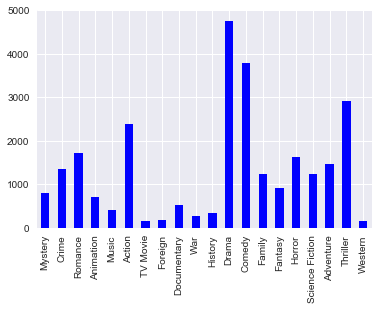

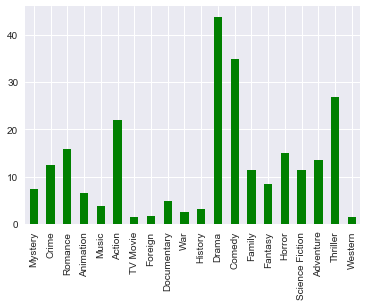

In [12]:
list_of_genres = list(set_of_genres)
frequencies = pd.Series(index=list_of_genres)
percentages = pd.Series(index=list_of_genres)
for genre in set_of_genres:
    number = extended_movies[genre].sum()
#    print 'Number of movies of genre ', genre, ':',number
    frequencies[genre]= number
    percentage = number / float(extended_movies[genre].count())*100.
    percentages[genre] = percentage
#    print 'percentage: ',percentage
plt.figure()
frequencies.plot(kind='bar',color='b')
plt.figure()
percentages.plot(kind='bar',color='g')


We observe that the most frequent genres are Drama and Comedy and just behind Thriller and Action. This is a little bit confusing because as expressed by the pipe lists in the original data, a movie can be both an action film and a thriller. 
We learn more through specific genres like SciFi and Western for example.

And it does say nothing about popularity because there are far less films of SciFi than Comedies for example. 

Let us now focus on the time history of these data to see if we can observe some trends


In [13]:
# Conversion of booleans in integers to be able to perform linear algebra operations
for genre in set_of_genres:
    extended_movies[genre] = extended_movies[genre].map(int)

# Data are grouped per release_year in order to study time evolution through years    
grouped = extended_movies.groupby('release_year')

We will first investigate the frequency evolution

Drama              85.000000
Comedy             67.732143
Thriller           51.910714
Action             42.571429
Romance            30.571429
Horror             29.232143
Adventure          26.267857
Crime              24.178571
Family             21.982143
Science Fiction    21.946429
Fantasy            16.357143
Mystery            14.464286
Animation          12.482143
Documentary         9.285714
Music               7.285714
History             5.964286
War                 4.821429
Foreign             3.357143
TV Movie            2.982143
Western             2.946429
dtype: float64


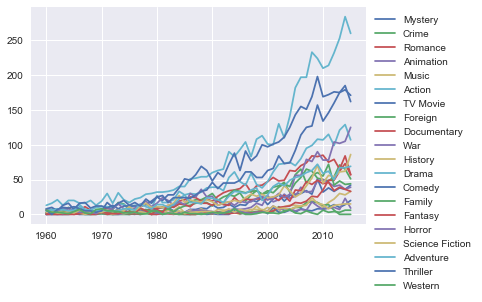

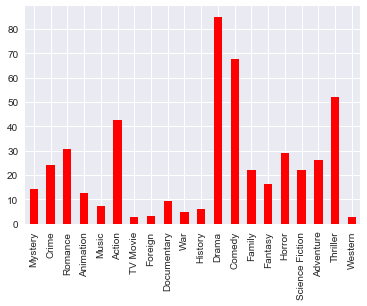

In [14]:
hist_genre = pd.DataFrame()

for genre in set_of_genres:
    values = grouped.sum()[genre]
#   gives a Series with frequencies per year
    hist_genre[genre] = values
#   build a dataframe with each column being a frequency history for a specific genre
    index = hist_genre.index
    plt.plot(index,values)
plt.legend(list(set_of_genres),bbox_to_anchor=(1,1))
plt.figure()
print hist_genre.mean().sort_values(ascending=False)
hist_genre.mean().plot(kind='bar',color='r')

We observe that there is a regular ascendance of the movies whatever the genre, which is characteristic
of the growth of the cinema business. The means over years have the same profile as the previous means plotted
before grouping. 
But frequency is not popularity.
So let us try now to investigate popularity.

Drama              50.277102
Comedy             40.138565
Action             39.432826
Thriller           38.495065
Adventure          30.319912
Science Fiction    21.980394
Romance            18.100794
Crime              18.011354
Family             17.292657
Fantasy            16.240021
Horror             13.603371
Animation          10.637053
Mystery             9.980533
Music               3.550483
War                 3.508472
History             3.435047
Western             1.740206
Documentary         1.684722
TV Movie            0.807850
Foreign             0.642881
dtype: float64


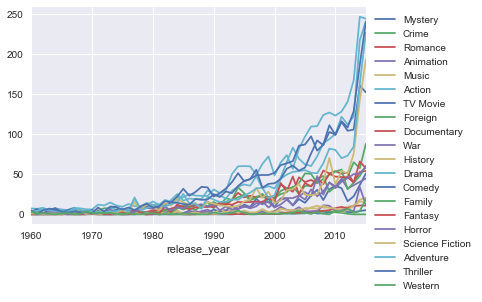

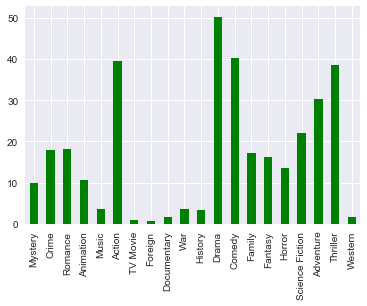

In [15]:
# We build an overall popularity index per genre through a scalar product between the popularity column 
# and each genre column which is equivalent to sum the popularities for each genre

for genre in set_of_genres:
    extended_movies['popularity_'+genre]=np.array(extended_movies['popularity']).T*np.array(extended_movies[genre])

# Recomputation of grouped to take into account the new columns    
grouped = extended_movies.groupby('release_year')
plt.figure()
hist_popularity_genre = pd.DataFrame()

for genre in set_of_genres:
    hist_popularity_genre[genre] = grouped.sum()['popularity_'+genre]
hist_popularity_genre.plot()
plt.legend(list(set_of_genres),bbox_to_anchor=(1,1))

plt.figure()
print hist_popularity_genre.mean().sort_values(ascending=False)
hist_popularity_genre.mean().plot(kind='bar',color='g')

I am still puzzled by these results, because for example Fantasy and Science Fiction do not receive the popularity
I would expect. I think that results are biased by the fact that Fantasy and Science Fiction are less frequent than other genres like Comedy (probably for budget reasons). Hence popularity should be normalize by the frequency.
Let us investigate this. 
I will also try to split the plot in 4 subplot, because having all 20 genres in a single plot is difficult to read.

Adventure          0.937627
Animation          0.817759
Fantasy            0.764171
Science Fiction    0.761651
Action             0.758278
Family             0.687518
Thriller           0.645160
Crime              0.643064
War                0.626728
Mystery            0.570070
Western            0.535108
History            0.518848
Drama              0.517394
Comedy             0.515554
Romance            0.514500
Music              0.462169
Horror             0.428542
TV Movie           0.284413
Documentary        0.191102
Foreign            0.182989
dtype: float64


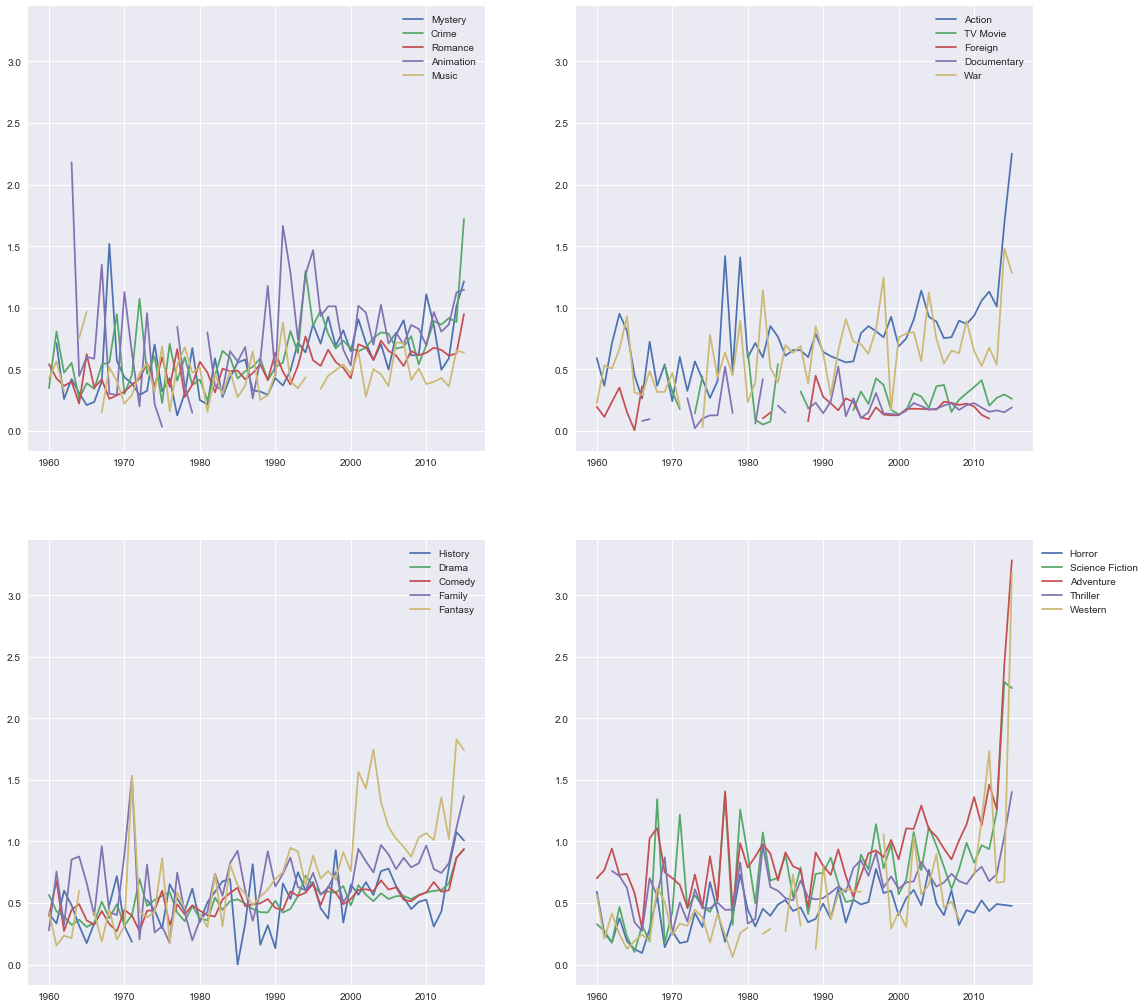

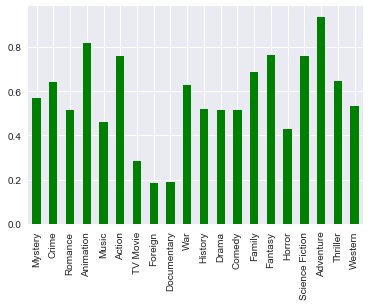

In [16]:
plt.figure(figsize=(18,18))
hist_popularity_genre_rel = pd.DataFrame()
nb_genres=len(set_of_genres)
ax=plt.subplot(2,2,1)
for ix,genre in enumerate(set_of_genres):
    values = grouped.sum()['popularity_'+genre]/hist_genre[genre]
    hist_popularity_genre_rel[genre] = values
    index = hist_popularity_genre_rel.index
    plt.subplot(2,2,ix/5+1,sharex=ax,sharey=ax)
    plt.plot(index,values)
    plt.legend(list(set_of_genres)[ix/5*5:ix/5*5+5],bbox_to_anchor=(1,1))

plt.subplots_adjust(wspace=0.2,hspace=0.2)
    
print hist_popularity_genre_rel.mean().sort_values(ascending=False)
plt.figure()
hist_popularity_genre_rel.mean().plot(kind='bar',color='g')

Now results look much more in line with the intuition. Looking at the bar diagramm and the sorted means, we can see that the top 5 is now closer to our intuition because now including Fantasy and SciFi.  
Moreover popularity is not any longer an ascending curve except maybe for some genres. We could imagine that the development of the cimema industry and technologies make some genres more appealing like fantasy, adventure, scifi growing in the last 20 years. Also the more you have movies in a genre, the more you have chance to have a popular movie.

Some peaks also deserves a more detailed analysis.

First latest data for year 2015 look peaky for lot of genres.

When looking at the table, we find two very large peaks (around 30 !) in 2015 for "Jurassic World" and "Mad Max: Fury Road" as they are both Action|Adventure|Science Fiction|Thriller, they create peaks for all these genres.
But I do not understand why these values are so high, because I am not sure that Jurassic World had more popularity than Star Wars. The revenue is higher and the vote average also. 
There could be a mistake in these data or a change in the way the popularity is computed.

Other peaks are interesting to analyze and matches particular famous movies.


Peaks for fantasy movies

In [17]:
# investigate peak in 1971 for fantasy genre

print '1971 peaks:'
for ix,movie in extended_movies.iterrows():
    if movie['Fantasy'] == 1 and (movie['release_year'] == 1971):
        print movie['popularity'],movie['original_title']        
        
        
# investigate peaks in early 2000s for fantasy genre

print ' '
print 'Early 2000s peaks:'
for ix,movie in extended_movies.iterrows():
    if movie['Fantasy'] == 1 and (2001 <= movie['release_year'] <= 2004):
        print movie['popularity'],movie['original_title'],movie['release_year']


1971 peaks:
2.430667 Willy Wonka & the Chocolate Factory
0.630778 Bedknobs and Broomsticks
 
Early 2000s peaks:
8.575419 The Lord of the Rings: The Fellowship of the Ring 2001
8.021423 Harry Potter and the Philosopher's Stone 2001
3.851009 Donnie Darko 2001
3.204295 Monsters, Inc. 2001
2.918566 Shrek 2001
2.449323 The Mummy Returns 2001
2.179727 Lara Croft: Tomb Raider 2001
1.213215 Jimmy Neutron: Boy Genius 2001
0.974222 Final Fantasy: The Spirits Within 2001
0.913069 Dr. Dolittle 2 2001
0.883228 Kate & Leopold 2001
0.493548 Down to Earth 2001
0.467592 The Mists of Avalon 2001
0.356425 Just Visiting 2001
0.282381 Prince Charming 2001
0.271443 Jack and the Beanstalk: The Real Story 2001
0.269944 Max Keeble's Big Move 2001
0.263042 Monkeybone 2001
0.224439 Snow White 2001
0.906593 Black Knight 2001
0.115221 Dagon 2001
0.114896 Halloweentown II: Kalabar's Revenge 2001
0.100277 BelphÃ©gor - Le fantÃ´me du Louvre 2001
0.080857 The Lost World 2001
0.001349 Slashers 2001
8.095275 The Lord of

In 1971 there were very few fantasy films, but one had a respectable success: the first version of Charly and the Chocolate Factory wiht the regretted Gene Wilder.

The early 2000s peaks are linked to the Lord of the Rings first episodes, Harry Potter and also to Pirate of the Carribeans and UnderWorld. So big Fantasy blockbusters in these early 20s.

In the peaks for science fiction we can probably read the success of Kubrik's '2001 Space Odyssey' in late 60s, then the Star Wars movies in late 70s. 
Let us check:

In [18]:
print ' '
print 'Late 60s Science Fiction Movies'
for ix,movie in extended_movies.iterrows():
    if movie['Science Fiction'] == 1 and (1965 <= movie['release_year'] < 1970):
        print movie['popularity'],movie['original_title'],movie['release_year']
        
print ' '
print 'Late 70s Science Fiction Movies'
for ix,movie in extended_movies.iterrows():
    if movie['Science Fiction'] == 1 and (1975 < movie['release_year'] < 1980):
        print movie['popularity'],movie['original_title'],movie['release_year']

 
Late 60s Science Fiction Movies
3.309196 2001: A Space Odyssey 1968
1.152937 Planet of the Apes 1968
0.867192 Barbarella 1968
0.045242 Charly 1968
0.311525 Quatermass and the Pit 1967
0.109398 Spider Baby 1967
0.154786 KaijÅ«tÅ no Kessen: Gojira no Musuko 1967
0.174153 Frankenstein Created Woman 1967
0.199141 Dr. Goldfoot and the Bikini Machine 1965
0.00477 Die, Monster, Die! 1965
0.26714 The Valley of Gwangi 1969
0.141056 Hercules in New York 1969
0.109424 DoppelgÃ¤nger 1969
0.929393 Fahrenheit 451 1966
0.410366 Batman 1966
0.236098 Our Man Flint 1966
0.034555 Island of Terror 1966
0.207257 Fantastic Voyage 1966
0.089072 Seconds 1966
 
Late 70s Science Fiction Movies
12.037933 Star Wars 1977
1.104816 Close Encounters of the Third Kind 1977
0.75125 Sinbad and the Eye of the Tiger 1977
0.331417 Eraserhead 1977
0.164123 Kingdom of the Spiders 1977
0.175657 Wizards 1977
0.24469 Demon Seed 1977
0.114062 The Island of Dr. Moreau 1977
0.108321 Empire of the Ants 1977
0.046957 Day of the An

My guess is confirmed but I forgot "Planet of the Apes" and "Barbarella" the same year as "2001".
I also forgot "Close Encounter of the Third Kind" the same year as the first "Star Wars".


### What kinds of properties are associated with movies that have high revenues?

          id    imdb_id  popularity       budget       revenue  \
1386   19995  tt0499549    9.432768  237000000.0  2.781506e+09   
3     140607  tt2488496   11.173104  200000000.0  2.068178e+09   
5231     597  tt0120338    4.355219  200000000.0  1.845034e+09   
4361   24428  tt0848228    7.637767  220000000.0  1.519558e+09   
0     135397  tt0369610   32.985763  150000000.0  1.513529e+09   
4     168259  tt2820852    9.335014  190000000.0  1.506249e+09   
14     99861  tt2395427    5.944927  280000000.0  1.405036e+09   
3374   12445  tt1201607    5.711315  125000000.0  1.327818e+09   
5422  109445  tt2294629    6.112766  150000000.0  1.274219e+09   
5425   68721  tt1300854    4.946136  200000000.0  1.215440e+09   

                                    original_title  \
1386                                        Avatar   
3                     Star Wars: The Force Awakens   
5231                                       Titanic   
4361                                  The Avengers   
0  

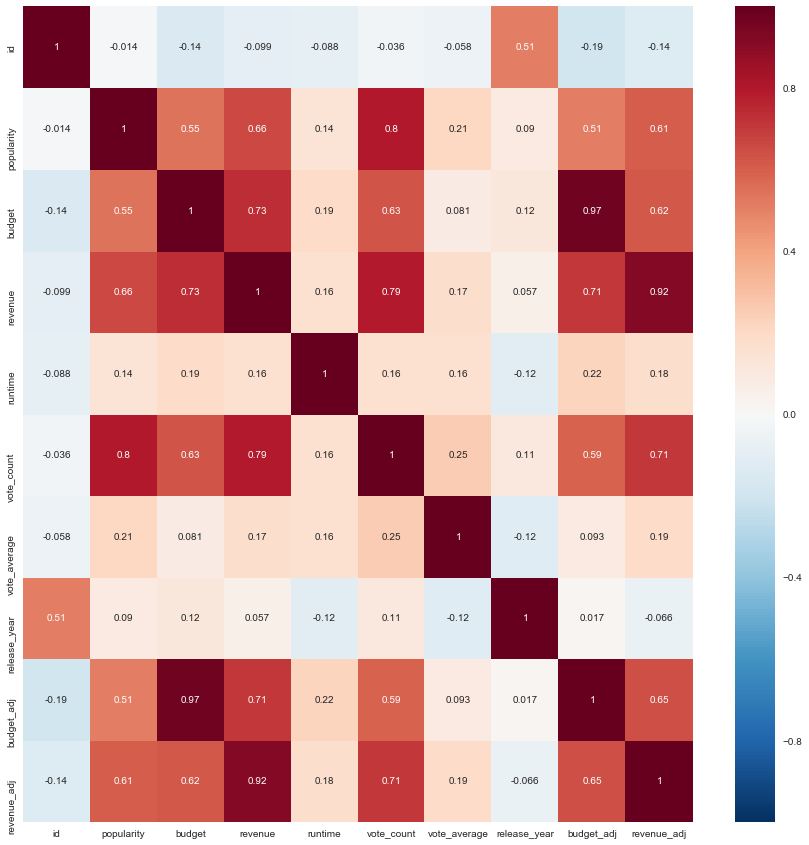

In [19]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
print cleaned_movies.sort_values('revenue',ascending=False).head(10)
plt.figure(figsize=(15,15))
print sns.heatmap(cleaned_movies.corr(), annot=True) 


With this plot of correlation matrix and associated colors, we can find easily which factors are correlated with revenues. Let us not forget that this is about correlation and not causation. To claim for causality which should go through more intensive inquiries.

So apparently revenue is correlated in decreasing order to:
- revenue_adj: it is normal additional revenues is proportional to baseline revenue
- vote_count: normally a movie which gathers many votes also had a lot of audience and a large revenue
- budget: The budget of a movie is linked to the expected revenue
- budget_adj: which is tightly correlated to budget
- popularity: same as for vote_count
All other factors are poorly correlated.

Note that there is not a full correlation between popularity and vote because of the popularity index which is rather complex as explained in https://developers.themoviedb.org/3/getting-started/popularity

We could imagine to look for correlations with the extended_movies dataframe additional factors, but I do not think it makes sense. There will be correlation to genres but through popularity, so we will just find that the correlation is higher for genres with high popularity.
Let us try to test it anyway.





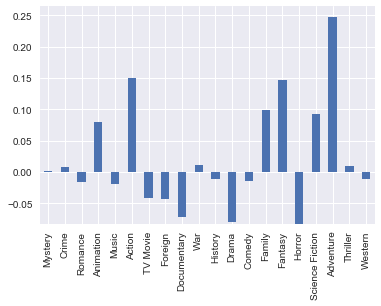

In [20]:
corrmat = extended_movies.corr()
revenue_of_genre = corrmat.loc['revenue','Mystery':'Western']
revenue_of_genre.plot(kind='bar')

So, no big surprise there: best correlation is found for the most popular genres.

<a id='conclusions'></a>
## Conclusions

> ** Most popular genres **: The most popular genres are not directly linked to the number of films in the genre. Hence a normalization with respect to this number of movies was preferrable and gives better results.
Once done, we find that the 5 most popular genres are:
- Adventure          0.937627
- Animation          0.817759
- Fantasy            0.764171
- Science Fiction    0.761651
- Action             0.758278

> Strange popularity values were found for some 2015 movies with the largest popularity level ever met in the history, but for two movies which are not really outstanding. It would require some checks from IMDB regarding this column or potential recent changes in the way they calculate the popularity index.



> ** Revenue **: No big discovery with respect to the revenue correlation. All correlations found are quite nautral and make sense. The correlation to budget just means that cinema industry investments are rather rational: they invest budget in relationship with the revenue of the movie. And the correlation with popularity is also natural: popularity is linked to the audience and the revenue is linked to the audience.




